# DATASET ANALYSIS

## IMPORTS


In [229]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer

from fairlearn.datasets import fetch_adult
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from fairlearn.reductions import DemographicParity

import shap

## LOAD DATASET


In [230]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

data_positive_targets = data.loc[data['checked'] == 1]
# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## DISTRIBUTION OF TARGET VALUE

<Axes: xlabel='checked', ylabel='count'>

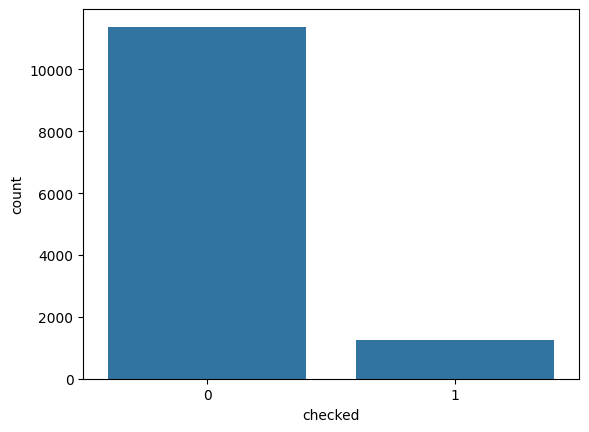

In [231]:
# Visualize the distribution of the target variable 'checked'
sns.countplot(x='checked', data=data)

In [232]:


# Create a dropdown menu with all the features
feature_dropdown = widgets.Dropdown(
    options=data.columns,
    description='Feature:',
)

# Create a new output area for the dropdown menu
output = widgets.Output()

# Define a function to update the plot when a new feature is selected
def update_plot(feature):
    with output:
        clear_output(wait=True)  # Clear the current output
        sns.histplot(data=data, x=feature, legend=True, bins="auto")
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature}')
        plt.show()

# Display the dropdown menu and the initial plot
display(feature_dropdown)
display(output)

# Call the update_plot function when a new feature is is selected
feature_dropdown.observe(lambda change: update_plot(change.new), names='value')

Dropdown(description='Feature:', options=('adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adre…

Output()

## INITIALIZE SELECTORS


In [233]:
# Select data based on variance (not the final version yet, for now just for testing)
selector = VarianceThreshold(threshold=0.1)

In [ ]:
numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

## ANALYSE BIAS IN MODEL PREDICTIONS


In [234]:
# Define a gradient boosting classifier
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [235]:
# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
pipeline = Pipeline(steps=[('selector', selector), ("preprocessor", preprocessor) ('classification', classifier)])



In [236]:
# Let's train a simple model
pipeline.fit(X_train, y_train)

# Let's evaluate the model
y_pred = pipeline.predict(X_test)

original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)

Accuracy of the original model:  0.9032258064516129


In [237]:
y_pred = pipeline.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Confusion Matrix


In [238]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[2845   11]
 [ 295   11]]


## Classification Report

In [239]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2856
           1       0.50      0.04      0.07       306

    accuracy                           0.90      3162
   macro avg       0.70      0.52      0.51      3162
weighted avg       0.87      0.90      0.86      3162



## ROC Curve and AUC

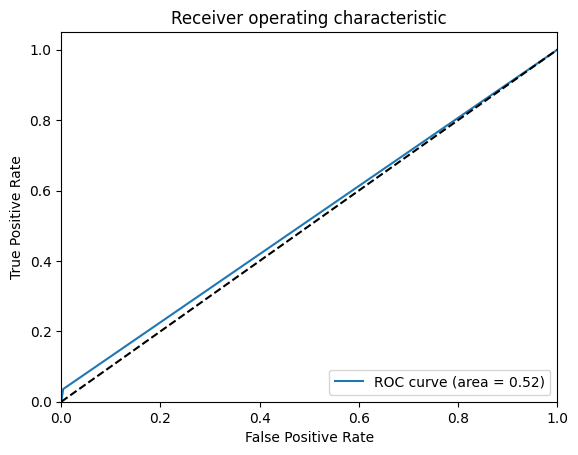

In [240]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

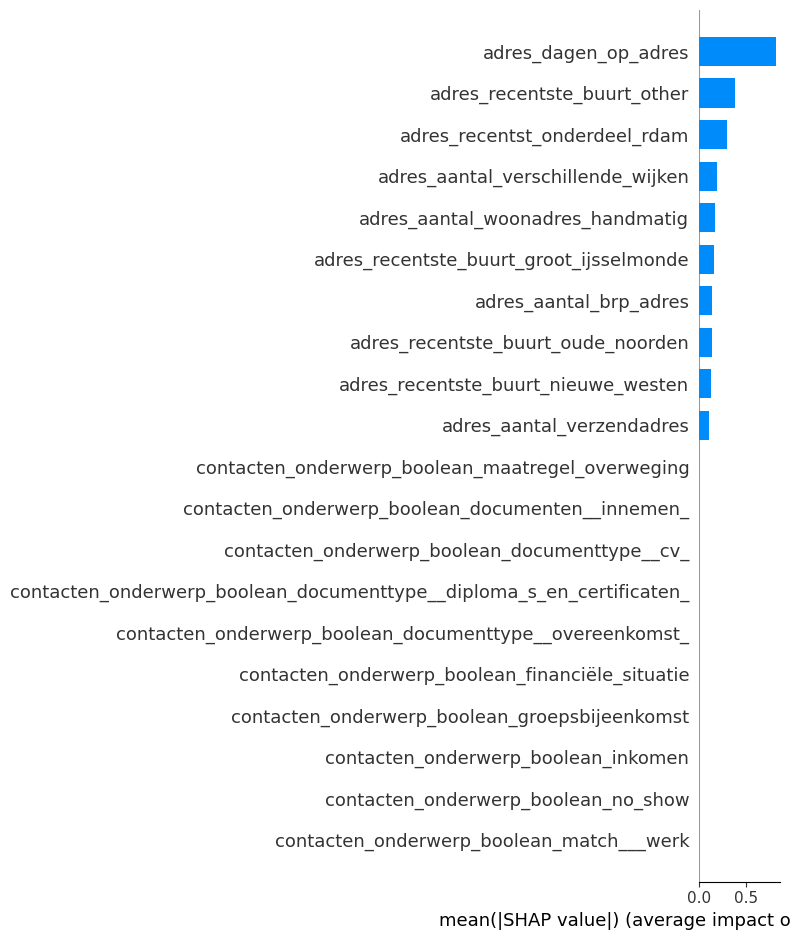

In [241]:

# Create a TreeExplainer for the GradientBoostingClassifier model
explainer = shap.TreeExplainer(pipeline.named_steps['classification'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [250]:
m_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=y_test)
m_eqo = equalized_odds_ratio(y_test, y_pred, sensitive_features=y_test)
print(f'Value of demographic parity ratio: {round(m_dpr, 2)}')
print(f'Value of equal odds ratio: {round(m_eqo, 2)}')

TypeError: StructuredDataset.__init__() got an unexpected keyword argument 'labels_names'